# Initializing

In [ ]:
# mounting google drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Work/Mina')
print("Current working directory: {0}".format(os.getcwd()))

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/Work/Mina


In [ ]:
# Installing requiered packages
!pip install mne
!pip install pyhrv
!pip install neurokit2
!pip install wget
!pip install nsrr
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=55d11103a1b0cb60dfe6087dadad165a333a7769291de4cc2d651416ee7f1eba
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


# MIT-BIH

## Loading

In [ ]:
def splitSignal(sig, rate, seconds, overlap):
    # Split signal with overlap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]
        
        # Signal chunk too short?
        if len(split) < int(rate * seconds):
            split = np.hstack((split, np.zeros((int(rate * seconds) - len(split),))))
        
        sig_splits.append(split)

    return sig_splits 
#end splitSignal

In [ ]:
# importing libraries
import wfdb
import numpy as np
import neurokit2 as nk
import warnings

In [ ]:
# Changing Current Directory to Dataset Folder Path
import os  
path = '/content/drive/MyDrive/Work/Mina/MITBIH'
os.chdir(path) 
print('[INFO] Current Directory is:', os.getcwd())

In [ ]:
# reading each subject and extracting ECG signal and corresponding apnea label
import wfdb
import numpy as np
import neurokit2 as nk
import warnings

warnings.filterwarnings("ignore")

mitbih_filenames = ['slp01a','slp01b','slp02a','slp02b','slp03','slp04','slp14',
                    'slp16','slp32','slp37','slp41','slp45','slp48','slp59','slp60','slp61','slp66','slp67x']

MITBIH_ECG_X=[]
MITBIH_ECG_Y=[]

for j in range(0,len(mitbih_filenames)):
    # Extracting ECG Data
    ecg_sig, fields = wfdb.rdsamp('mit-bih-polysomnographic-database-1.0.0/' + mitbih_filenames[j], channels =[0])
    ann = wfdb.rdann(mitbih_filenames[j], 'st',pn_dir='slpdb',return_label_elements=['label_store'],summarize_labels=True)
    labels=ann.__dict__["aux_note"]
    ecg_sig_trans = np.transpose(ecg_sig)

    # Preprocessing ECG Data
    # Baseline Wander and High-Frequency Noise Removal using Butterworth Filter (1-70 Hz) order=4
    ecg_filtered = nk.signal.signal_filter(ecg_sig_trans, sampling_rate=250, lowcut=1, highcut=50, method='butterworth', order=4, powerline=50)
    ecg_transposed = np.transpose(ecg_filtered)

    ecg_segment= splitSignal(ecg_transposed, 250, 30, 0)

    print(mitbih_filenames[j])
    print(len(ecg_segment))
    print(len(labels))

    for i in range(0,min([len(labels), len(ecg_segment)])):

        if 'W' in labels[i] or 'H' in labels[i] or 'HA' in labels[i]:
          []
        else:
          # print(i)
          
            try:
              if "OA" in labels[i] or "X" in labels[i]:
                MITBIH_ECG_Y.append(1)
                MITBIH_ECG_X.append(ecg_segment[i])

                #Duplicating
                MITBIH_ECG_Y.append(1)
                MITBIH_ECG_X.append(ecg_segment[i])
              #end if
                
              if "CA" in labels[i] or "CAA" in labels[i]:
                MITBIH_ECG_Y.append(2)
                MITBIH_ECG_X.append(ecg_segment[i])

                #Duplicating
                MITBIH_ECG_Y.append(2)
                MITBIH_ECG_X.append(ecg_segment[i])
                MITBIH_ECG_Y.append(2)
                MITBIH_ECG_X.append(ecg_segment[i])

              else:
                MITBIH_ECG_Y.append(0)  
                MITBIH_ECG_X.append(ecg_segment[i])
              #end if

            except:
               print("Error for {}".format(i))
        #end if
    #end for
#end for


In [ ]:
# # Saveing Loaded dataset in a File
import pickle

# Saving the objects:
with open('MITBIH_ECG.pkl', 'wb',) as f:  # Python 3: open(..., 'wb')
    pickle.dump([MITBIH_ECG_X, MITBIH_ECG_Y], f,)

In [ ]:
# checking different classes count
print('normal')
print(MITBIH_ECG_Y.count(0))

print('obstructive')
print(MITBIH_ECG_Y.count(1))

print('central')
print(MITBIH_ECG_Y.count(2))

# NCHSDB

## Loading

In [ ]:
# Changing Current Directory to Dataset Folder Path
import os  
path = '/content/drive/MyDrive/Work/Mina/NCHSDB'
os.chdir(path) 
print('[INFO] Current Directory is:', os.getcwd())

In [ ]:
# importing libraries
import sleep_study as ss
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
import neurokit2 as nk

In [ ]:
# Extracting file names
!pwd
ss.init()
NCHSDB_filenames = ss.data.init_study_list()
print(len(NCHSDB_filenames))
NCHSDB_filenames

334


['8380_1042',
 '8356_2923',
 '8371_12034',
 '8344_17575',
 '8350_12559',
 '8398_4084',
 '8386_11071',
 '8392_6397',
 '8374_10009',
 '8389_20047',
 '8398_26014',
 '8404_4549',
 '8413_967',
 '8407_14038',
 '8410_23113',
 '8431_21844',
 '8470_13564',
 '8440_11311',
 '8425_18712',
 '8443_12766',
 '8446_22888',
 '844_21373',
 '8476_7153',
 '8485_160',
 '8476_19399',
 '8470_21298',
 '8491_10195',
 '8482_14029',
 '8506_14938',
 '8515_22030',
 '8509_15145',
 '8500_23035',
 '8512_14254',
 '8530_15619',
 '850_14323',
 '8563_17236',
 '8566_26173',
 '8581_13543',
 '856_16678',
 '8551_23725',
 '8593_7606',
 '8605_23317',
 '8539_2074',
 '8596_19555',
 '8590_17848',
 '859_25927',
 '8608_18625',
 '8638_4504',
 '8635_16111',
 '8626_19816',
 '8644_5014',
 '8665_11743',
 '8650_4177',
 '8665_11857',
 '8659_14041',
 '8647_23275',
 '8668_6322',
 '8674_20260',
 '8683_2401',
 '868_21865',
 '8689_3307',
 '8680_9913',
 '8701_10822',
 '8665_5530',
 '8710_26137',
 '8713_25723',
 '8710_5935',
 '8707_23248',
 '8725

In [ ]:
# k = 0
# ecg_channel_names = []
# for i in range(len(NCHSDB_filenames)):
#     raw = ss.data.load_study(NCHSDB_filenames[i])
#     channel_names = raw.ch_names
#     print(NCHSDB_filenames[i])
#     for c in channel_names:
#         if "ECG" in c:
#             k += 1
#             print(c)
#             ecg_channel_names.append(c)
#             print(100*'*')
#         #end if
#     #end for
# #end for
# print(k)

In [ ]:
# channel_names = raw.ch_names
# channel_names

In [ ]:
# checking sampeling rate
raw = ss.data.load_study(NCHSDB_filenames[0])
fc = int(raw.info['sfreq'])
fc
# ss.info.REFERENCE_FREQ

256

In [ ]:
# loading previous read data
ecg_channel_names = []
e = 0
a = 0
NCHSDB_ECG_X=[]
NCHSDB_ECG_Y=[] #0 normal, 1 obstructive, 2 central, 3 mix

# Loading Variables from a File
import pickle

# Getting back the objects:
with open('NCHSDB_ECG5.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    NCHSDB_ECG_X, NCHSDB_ECG_Y = pickle.load(f)


In [ ]:
# checking different classes count
print('normal')
print(NCHSDB_ECG_Y.count(0))

print('obstructive')
print(NCHSDB_ECG_Y.count(1))

print('central')
print(NCHSDB_ECG_Y.count(2))

print('mix')
print(NCHSDB_ECG_Y.count(3))

normal
1815
obstructive
1722
central
606
mix
293


In [ ]:
# reading each file and extracting ECG signal and corresponding apnea label

for i in range(0,len(NCHSDB_filenames)): #
    sleep_counter = 0
    
    #ECG signal extraction
    raw = ss.data.load_study(NCHSDB_filenames[i])
    fc = int(raw.info['sfreq'])
    channel_names = raw.ch_names
    print(50*'*')
    print(NCHSDB_filenames[i])
    print(fc)

    if fc != 512:
        for c in channel_names:
            if "ECG" in c:
                print('ECG found')
                e += 1
                ecg_channel_names.append(c) 
                ecg_signal = raw.get_data(c)

                

                if fc == 400:
                    ecg_signal = nk.signal_resample(ecg_signal, sampling_rate=fc, desired_sampling_rate=256)
                    fc = 256
                #end if

                ECG_filtered = nk.signal.signal_filter(ecg_signal, sampling_rate=fc, lowcut=1, highcut=40, method='butterworth', order=4)
                ECG_filtered = np.array(ECG_filtered[0])

                #Apnea annotation extraction
                annotation = raw.annotations
                print(fc)
                for a in range(len(annotation)-1):
                    start_second = int(annotation[a]['onset'])
                    try:
                        if 'Obstructive Apnea' in annotation[a]['description']:
                            NCHSDB_ECG_Y.append(1)
                            NCHSDB_ECG_X.append(ECG_filtered[(start_second-5)*fc:(start_second+25)*fc])
                            # print('obst ',a)
                            # a += 1
                        #end if
                        if 'Central Apnea' in annotation[a]['description']:
                            NCHSDB_ECG_Y.append(2)
                            NCHSDB_ECG_X.append(ECG_filtered[(start_second-5)*fc:(start_second+25)*fc])
                            # print('central ',a)
                            # a += 1
                        #end if       
                        if 'Mixed Apnea' in annotation[a]['description']:
                            NCHSDB_ECG_Y.append(3)
                            NCHSDB_ECG_X.append(ECG_filtered[(start_second-5)*fc:(start_second+25)*fc])
                            # print('mixed ',a)
                            # a += 1
                        #end if
                        if 'Sleep stage R' in annotation[a]['description'] and sleep_counter < 5:
                            NCHSDB_ECG_Y.append(0)
                            NCHSDB_ECG_X.append(ECG_filtered[(start_second-5)*fc:(start_second+25)*fc])
                            sleep_counter += 1
                            # print('sleep ',a)
                            # a += 1
                        #end if
                    except:
                        print("Something else went wrong")
                        break
                #end for
            #end if
        #end for
    #end if
#end for
print(50*'*')
print('e ',e)
print('a ',a)

**************************************************
9400_10396
256
ECG found
256
**************************************************
9397_18964
400
ECG found
256
**************************************************
9403_24481
400
ECG found
256
**************************************************
940_7147
256
ECG found
256
**************************************************
9415_2623
256
ECG found
256
**************************************************
9409_5437
256
ECG found
256
**************************************************
9418_18115
256
ECG found
256
**************************************************
9451_25366
256
ECG found
256
**************************************************
9427_1147
256
ECG found
256
**************************************************
9454_20410
256
ECG found
256
**************************************************
9403_16297
512
**************************************************
9433_22819
400
ECG found
256
**************************************************
9460_167

In [ ]:
# checking different classes count
print('normal')
print(NCHSDB_ECG_Y.count(0))

print('obstructive')
print(NCHSDB_ECG_Y.count(1))

print('central')
print(NCHSDB_ECG_Y.count(2))

print('mix')
print(NCHSDB_ECG_Y.count(3))

normal
2410
obstructive
2271
central
757
mix
402


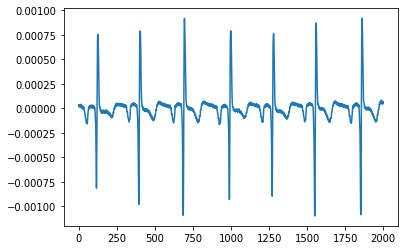

In [ ]:
#ploting an example of read signals
import matplotlib.pyplot as plt
plt.plot(NCHSDB_ECG_X[-3][0:2000])


In [ ]:
# Saveing Variables in a File
import pickle

# Saving the objects:
with open('NCHSDB_ECG5.pkl', 'wb',) as f:  # Python 3: open(..., 'wb')
    pickle.dump([NCHSDB_ECG_X, NCHSDB_ECG_Y], f,)

## Merging

In [ ]:
# Merging all the saved read data into one file
import pickle

pkl_filenames = ['NCHSDB_ECG1.pkl', 'NCHSDB_ECG2.pkl', 'NCHSDB_ECG3.pkl', 'NCHSDB_ECG4.pkl', 'NCHSDB_ECG5.pkl']
NCHSDB_ECG_X=[]
NCHSDB_ECG_Y=[] #0 normal, 1 obstructive, 2 central, 3 mix

for i in range(len(pkl_filenames)):
    print(pkl_filenames[i])
    # Getting back the objects:
    with open(pkl_filenames[i], 'rb') as f:  # Python 3: open(..., 'rb')
        temp_X, temp_Y = pickle.load(f)

    print(50*'*')
    print('normal')
    print(temp_Y.count(0))

    print('obstructive')
    print(temp_Y.count(1))

    print('central')
    print(temp_Y.count(2))

    print('mix')
    print(temp_Y.count(3))
    
    for k in range(len(temp_Y)):
        NCHSDB_ECG_X.append(temp_X[k])
        NCHSDB_ECG_Y.append(temp_Y[k])

print(50*'*')
print('FINAL')
print('normal')
print(NCHSDB_ECG_Y.count(0))

print('obstructive')
print(NCHSDB_ECG_Y.count(1))

print('central')
print(NCHSDB_ECG_Y.count(2))

print('mix')
print(NCHSDB_ECG_Y.count(3))

# Saving the objects:
with open('NCHSDB_ECG.pkl', 'wb',) as f:  # Python 3: open(..., 'wb')
    pickle.dump([NCHSDB_ECG_X, NCHSDB_ECG_Y], f,)

print(50*'*')
print("**********SAVED**********")

NCHSDB_ECG1.pkl
**************************************************
normal
6138
obstructive
2096
central
651
mix
259
NCHSDB_ECG2.pkl
**************************************************
normal
5758
obstructive
2272
central
1210
mix
331
NCHSDB_ECG3.pkl
**************************************************
normal
5440
obstructive
2735
central
1239
mix
562
NCHSDB_ECG4.pkl
**************************************************
normal
5305
obstructive
3411
central
2247
mix
699
NCHSDB_ECG5.pkl
**************************************************
normal
2410
obstructive
2271
central
757
mix
402
**************************************************
FINAL
normal
25051
obstructive
12785
central
6104
mix
2253
**************************************************
**********SAVED**********


# CFS

## Loading

In [ ]:
# Changing Current Directory to Dataset Folder Path
import os  
path = '/content/drive/MyDrive/Work/Mina/CFS'
os.chdir(path) 
print('[INFO] Current Directory is:', os.getcwd())

[INFO] Current Directory is: /content/drive/MyDrive/Work/Mina/CFS


In [ ]:
# finding edf files (signals)
edf_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".edf"):
            edf_paths.append(os.path.join(root, file))
print(len(edf_paths),"EDF Paths:")
print(edf_paths)

729 EDF Paths:
['/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800002.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800010.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800011.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800017.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800021.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800024.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800027.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800032.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800035.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800037.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-800038.edf', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/edfs/cfs-visit5-8

In [ ]:
# finding xml files (annotations)
xml_paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".xml") and 'nsrr' in file:
            xml_paths.append(os.path.join(root, file))
print(len(xml_paths),"XML Paths:")
print(xml_paths)

730 XML Paths:
['/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800010-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800002-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800011-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800017-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800021-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800024-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800027-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800032-nsrr.xml', '/content/drive/MyDrive/Work/Mina/CFS/polysomnography/annotations-events-nsrr/cfs-visit5-800035-nsrr.xml', '/content/drive/MyDri

In [ ]:
# reading each signal and corresponding annotation file

from bs4 import BeautifulSoup
import neurokit2 as nk
from mne.io import read_raw_edf
import mne

cfs_ecg_1_x = []
cfs_ecg_2_x = []

cfs_ecg_1_y = []
cfs_ecg_2_y = []

fc = 250

start_number = 500
for j in xml_paths[start_number:start_number+100]:
    apnea_status = False
    name = j.split('/')[-1].split('-')[-2]
    print(name)
    print(j)
    events = []
    starts = []
    durations = []
    with open(j, 'r') as f:
        ann = f.read()
    Bs_data = BeautifulSoup(ann, "xml")
    EventConcept = Bs_data.find_all('EventConcept')
    Start = Bs_data.find_all('Start')
    Duration = Bs_data.find_all('Duration')

    for i in range(len(EventConcept)):
        events.append(str(EventConcept[i]).split('>')[1].split('<')[0])
        starts.append(str(Start[i]).split('>')[1].split('<')[0])
        durations.append(str(Duration[i]).split('>')[1].split('<')[0])
    #end for

    for i in range(len(events)):
        if "Central Apnea" in events[i] or "Obstructive Apnea" in events[i] or "Mixed Apnea" in events[i]:
            apnea_status = True
            break
        #end if
    #end for

    #Loading EDF file 
    for i in range(len(edf_paths)):
        if name in edf_paths[i]:
            print(edf_paths[i])
            ecg1 = []
            ecg2 = []
            ecg_signal_number = 1
            edf_data=read_raw_edf(edf_paths[i])
            fs = edf_data.info['sfreq']
            print(fs)
            channels = edf_data.ch_names
            for c in channels:
                if "ECG" in c:
                    if ecg_signal_number == 1:
                        ecg1 = edf_data[c][0][0]
                        ecg1 = nk.signal_resample(ecg1, sampling_rate=fs, desired_sampling_rate=fc)
                        ecg_signal_number = 2

                    if ecg_signal_number == 2:
                        ecg2 = edf_data[c][0][0]
                        ecg2 = nk.signal_resample(ecg2, sampling_rate=fs, desired_sampling_rate=fc)
                    #end if
                #end if
            #end for
            break
        #end if
    #end for

    for i in range(len(events)):
        if "Central Apnea" in events[i]:
            if len(ecg1) > 1:
                start_second = int(float(starts[i]))
                cfs_ecg_1_x.append(ecg1[(start_second-5)*fc:(start_second+25)*fc])
                cfs_ecg_1_y.append(2)

            if len(ecg2) > 1:
                start_second = int(float(starts[i]))
                cfs_ecg_2_x.append(ecg2[(start_second-5)*fc:(start_second+25)*fc])
                cfs_ecg_2_y.append(2)
            #end if
        elif "Obstructive Apnea" in events[i]:
            if len(ecg1) > 1:
                start_second = int(float(starts[i]))
                cfs_ecg_1_x.append(ecg1[(start_second-5)*fc:(start_second+25)*fc])
                cfs_ecg_1_y.append(1)

            if len(ecg2) > 1:
                start_second = int(float(starts[i]))
                cfs_ecg_2_x.append(ecg2[(start_second-5)*fc:(start_second+25)*fc])
                cfs_ecg_2_y.append(1)
            #end if
        elif "Mixed Apnea" in events[i]:
            if len(ecg1) > 1:
                start_second = int(float(starts[i]))
                cfs_ecg_1_x.append(ecg1[(start_second-5)*fc:(start_second+25)*fc])
                cfs_ecg_1_y.append(3)

            if len(ecg2) > 1:
                start_second = int(float(starts[i]))
                cfs_ecg_2_x.append(ecg2[(start_second-5)*fc:(start_second+25)*fc])
                cfs_ecg_2_y.append(3)
            #end if
        #end if

#end for
                

In [ ]:
# free-up RAM
import numpy as np
for i in range(len(cfs_ecg_2_x)):
  try:
    if len(np.array(cfs_ecg_1_x[i])) != 7500 or len(np.array(cfs_ecg_2_x[i])) != 7500:
      print(i)
      cfs_ecg_1_x = np.delete(np.array(cfs_ecg_1_x), i, 0)
      cfs_ecg_2_x = np.delete(np.array(cfs_ecg_2_x), i, 0)
      cfs_ecg_1_y = np.delete(np.array(cfs_ecg_1_y), i, 0)
      cfs_ecg_2_y = np.delete(np.array(cfs_ecg_2_y), i, 0)

      cfs_ecg_1_x = np.array(list(cfs_ecg_1_x))
      cfs_ecg_2_x = np.array(list(cfs_ecg_2_x))
      cfs_ecg_1_y = np.array(list(cfs_ecg_1_y))
      cfs_ecg_2_y = np.array(list(cfs_ecg_2_y))
  except:
    None


In [ ]:
# checking different classes count

print('normal')
print(list(cfs_ecg_1_y).count(0))

print('obstructive')
print(list(cfs_ecg_1_y).count(1))

print('central')
print(list(cfs_ecg_1_y).count(2))

print('mix')
print(list(cfs_ecg_1_y).count(3))

normal
0
obstructive
2208
central
423
mix
4


In [ ]:
# Saveing Variables in a File
import pickle

# Saving the objects:
with open('CFS_ECG6.pkl', 'wb',) as f:  # Python 3: open(..., 'wb')
    pickle.dump([cfs_ecg_1_x, cfs_ecg_2_x, cfs_ecg_1_y, cfs_ecg_2_y], f,)

## Merging

In [ ]:
# Merging all the saved read data into one file
import pickle
import numpy as np

#   
pkl_filenames = ['CFS_ECG1.pkl','CFS_ECG2.pkl','CFS_ECG3.pkl', 'CFS_ECG4.pkl','CFS_ECG5.pkl','CFS_ECG6.pkl','CFS_ECG7.pkl', 'CFS_ECG8.pkl']
CFS_ECG_X=[]
CFS_ECG_Y=[] #0 normal, 1 obstructive, 2 central, 3 mix

for i in range(len(pkl_filenames)):
    print(pkl_filenames[i])
    # Getting back the objects:
    with open(pkl_filenames[i], 'rb') as f:  # Python 3: open(..., 'rb')
        cfs_ecg_1_x, cfs_ecg_2_x, cfs_ecg_1_y, cfs_ecg_2_y = pickle.load(f)

    cfs_ecg_1_x = np.array(list(cfs_ecg_1_x))
    cfs_ecg_2_x = np.array(list(cfs_ecg_2_x))
    cfs_ecg_1_y = np.array(list(cfs_ecg_1_y))
    cfs_ecg_2_y = np.array(list(cfs_ecg_2_y))

    cfs_ecg_1_x = np.array(cfs_ecg_1_x)
    cfs_ecg_1_y = np.array(cfs_ecg_1_y)

    cfs_ecg_2_x = np.array(cfs_ecg_2_x)
    cfs_ecg_2_y = np.array(cfs_ecg_2_y)

    cfs_ecg_12_x = np.concatenate((cfs_ecg_1_x, cfs_ecg_2_x))
    cfs_ecg_12_y = np.concatenate((cfs_ecg_1_y, cfs_ecg_2_y))

    cfs_ecg_12_x = np.array(cfs_ecg_12_x)
    cfs_ecg_12_y = np.array(cfs_ecg_12_y)

    print(cfs_ecg_1_x.shape)
    print(len(cfs_ecg_1_y))

    print(cfs_ecg_2_x.shape)
    print(len(cfs_ecg_2_y))


    print(cfs_ecg_12_x.shape)
    print(len(cfs_ecg_12_y))

    print(50*'*')
    print('normal')
    print(list(cfs_ecg_12_y).count(0))

    print('obstructive')
    print(list(cfs_ecg_12_y).count(1))

    print('central')
    print(list(cfs_ecg_12_y).count(2))

    print('mix')
    print(list(cfs_ecg_12_y).count(3))
    
    for k in range(len(cfs_ecg_12_y)):
        CFS_ECG_X.append(cfs_ecg_12_x[k])
        CFS_ECG_Y.append(cfs_ecg_12_y[k])

print(50*'*')
print('FINAL')
print('normal')
print(CFS_ECG_Y.count(0))

print('obstructive')
print(CFS_ECG_Y.count(1))

print('central')
print(CFS_ECG_Y.count(2))

print('mix')
print(CFS_ECG_Y.count(3))

# Saving the objects:
with open('CFS_ECG.pkl', 'wb',) as f:  # Python 3: open(..., 'wb')
    pickle.dump([CFS_ECG_X, CFS_ECG_Y], f,)

print(50*'*')
print("**********SAVED**********")

CFS_ECG1.pkl
(2580, 7500)
2580
(2580, 7500)
2580
(5160, 7500)
5160
**************************************************
normal
0
obstructive
4796
central
364
mix
0
CFS_ECG2.pkl
(2019, 7500)
2019
(2019, 7500)
2019
(4038, 7500)
4038
**************************************************
normal
0
obstructive
3234
central
804
mix
0
CFS_ECG3.pkl
(2533, 7500)
2533
(2533, 7500)
2533
(5066, 7500)
5066
**************************************************
normal
0
obstructive
4368
central
696
mix
2
CFS_ECG4.pkl
(2346, 7500)
2346
(2346, 7500)
2346
(4692, 7500)
4692
**************************************************
normal
0
obstructive
4216
central
476
mix
0
CFS_ECG5.pkl
(2975, 7500)
2975
(2975, 7500)
2975
(5950, 7500)
5950
**************************************************
normal
0
obstructive
5446
central
468
mix
36
CFS_ECG6.pkl
(2635, 7500)
2635
(2635, 7500)
2635
(5270, 7500)
5270
**************************************************
normal
0
obstructive
4416
central
846
mix
8
CFS_ECG7.pkl
(2964, 7500)
2

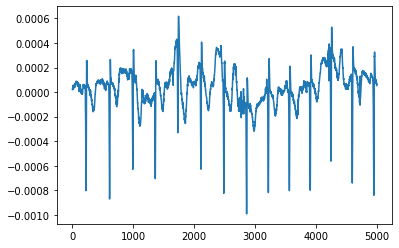

In [ ]:
# ploting an example of the read ECG signals
plt.plot(edf1_dict['800037'][0][0][5000:10000])